In [1]:
import numpy as np
import mikeio
from mikeio.pfs import PfsCore


basefolder = "C:\data\Lake\work"
obsfolder = "C:\data\Lake\obs"

pfs = PfsCore(r"C:\data\Lake\template\Lake.sw")


def run_simulation(charnock, roughness):
    wind_section = pfs.section("SPECTRAL_WAVE_MODULE").section("WIND")
    wind_section["background_Charnock_parameter"] = charnock # 0.01

    bf = pfs.section("SPECTRAL_WAVE_MODULE").section("BOTTOM_FRICTION")
    bf.section("NIKURADSE_ROUGHNESS")["constant_value"] = roughness # 0.04

    filename = os.path.join(basefolder,f"lake.sw")
    pfs.write(filename)
    cmdline = f"FemEngineSW {filename}"
    os.system(cmdline)

##########################################
# TODO replace this part with mikefm_skill
def calculate_residuals() -> np.ndarray:

    resultsfolder = os.path.join(basefolder,f"lake.sw - Result Files")
    
    obs = mikeio.read(os.path.join(obsfolder, "waves.dfs0"), items=0).to_dataframe().iloc[:,0]
    mod = mikeio.read(os.path.join(resultsfolder, "waves.dfs0"), items=0).to_dataframe().iloc[:,0]
    result = (obs - mod).values

    return result

def loss(residuals:np.ndarray) -> float:

    return np.sum(residuals**2)
##########################################

def f(x):
    run_simulation(charnock=x[0], roughness=x[1])
    res = calculate_residuals()
    l = loss(res)
    print(f"{x}: {l}")
    return l

Support for PFS files in mikeio is experimental. The API is likely to change!


In [2]:
%%time
run_simulation(charnock=0.008, roughness=0.05)

Wall time: 14.2 s


In [9]:
%%time
res = calculate_residuals()

Wall time: 20 ms


In [10]:
%%time 
loss(res)

Wall time: 0 ns


0.0

In [3]:
f(x=[0.012, 0.05])

[0.012, 0.05]: 0.026709809955556465


0.026709809955556465

In [2]:
f(x=[0.01, 0.04])

[0.01, 0.04]: 0.0


0.0

# Local optimisation

In [4]:
from scipy.optimize import minimize

r = minimize(f, x0=[0.005, 0.05], bounds=[(0.001, 0.1), (0.02, 0.06)])

[0.005 0.05 ]: 1.5997763371548446
[0.00500001 0.05      ]: 1.5995399820172755
[0.005      0.05000001]: 1.5997763371548446
[0.1  0.05]: 2.0406743309020543
[0.09999999 0.05      ]: 2.0406742558910667
[0.1        0.05000001]: 2.0406743309020543
[0.03665926 0.05      ]: 0.90600464686895
[0.03665927 0.05      ]: 0.9060047768716852
[0.03665926 0.05000001]: 0.90600464686895
[0.01555974 0.05      ]: 0.13549154362341792
[0.01555975 0.05      ]: 0.1354920420477045
[0.01555974 0.05000001]: 0.13549154362341792
[0.01553751 0.05      ]: 0.13447648193814862
[0.01553752 0.05      ]: 0.13447695045524127
[0.01553751 0.05000001]: 0.13447648193814862
[0.01544863 0.05      ]: 0.1307306334811662
[0.01544864 0.05      ]: 0.1307310171525359
[0.01544863 0.05000001]: 0.1307306334811662
[0.01507715 0.05      ]: 0.11740582139554691
[0.01507716 0.05      ]: 0.11740610299577511
[0.01507715 0.05000001]: 0.11740582139554691
[0.01405228 0.05      ]: 0.08260306699704376
[0.01405229 0.05      ]: 0.08260337851958349
[0.0

In [5]:
r

      fun: 2.6485503243703357e-13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.66366952e-05, 0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 7
     njev: 13
   status: 0
  success: True
        x: array([0.01, 0.05])

# Randomized search

In [11]:
nruns = 50

charnock  = np.random.uniform(0.001, 0.1,size=nruns)
roughness = np.random.uniform(0.02, 0.06, size=nruns)

In [12]:
parameters = np.column_stack([charnock, roughness])

parameters[0]

array([0.05677372, 0.03747078])

In [13]:
parameters.shape[0]

50

In [14]:
obj_values = [f(x=parameters[i]) for i in range(nruns)]    

[0.05677372 0.03747078]: 1.4284998248165501
[0.05719639 0.02739141]: 1.4375920339994543
[0.05383127 0.02521651]: 1.3622926713065675
[0.00149801 0.02585162]: 281.893532273492
[0.06016472 0.02157516]: 1.4986291554278082
[0.05886751 0.05554316]: 1.4715000479618712
[0.01845206 0.04561965]: 0.24800606683798754
[0.04634214 0.05425697]: 1.1848637527955679
[0.051505   0.03514667]: 1.3083906661886626
[0.04186436 0.03065061]: 1.0621768907683284
[0.04208504 0.02290768]: 1.0689025738965505
[0.00331564 0.03216372]: 284.9753976075552
[0.09578222 0.02364584]: 2.0058598745118097
[0.08756534 0.05892082]: 1.9190389224704132
[0.07391059 0.04137774]: 1.738366366327605
[0.08806737 0.03209156]: 1.9245780712624394
[0.07055556 0.05761541]: 1.6837990676271166
[0.07829503 0.02651143]: 1.801203980478623
[0.00902378 0.03300948]: 0.0096310808885808
[0.07348073 0.03818677]: 1.73163568857508
[0.09669049 0.04624366]: 2.011967483656269
[0.07069595 0.04352974]: 1.6860885813967932
[0.00905121 0.02075961]: 0.009018782704

In [18]:
import pandas as pd
df = pd.DataFrame({'loss': obj_values, 'roughness': roughness, 'charnock': charnock})

In [20]:
df.to_csv("calibration.csv")

In [25]:
df.index = df.index +1

<AxesSubplot:title={'center':'Random search'}, xlabel='Iteration #', ylabel='Loss'>

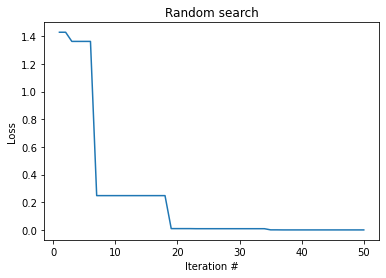

In [28]:
df.loss.cummin().plot(ylabel="Loss",xlabel="Iteration #", title="Random search")

<AxesSubplot:xlabel='roughness', ylabel='loss'>

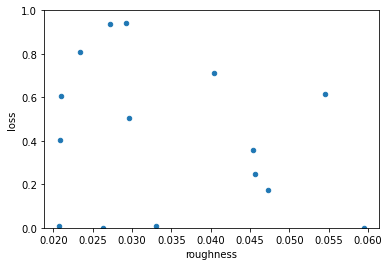

In [31]:
df.plot.scatter(x='roughness',y='loss',ylim=[0,1])

<AxesSubplot:xlabel='charnock', ylabel='loss'>

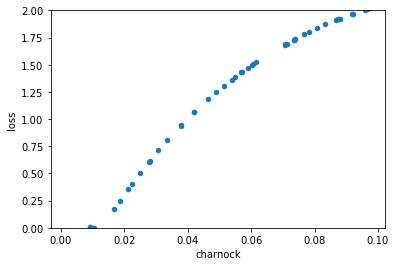

In [34]:
df.plot.scatter(x='charnock',y='loss',ylim=[0,2])

# Surrogate models
*interpolation in parameter space*

In [43]:
import gpflow
from gpflow.utilities import print_summary

In [234]:
nsamples = 50
X=df[['charnock','roughness']].values[:nsamples]
X.shape

(50, 2)

In [235]:
Y = df['loss'].values.reshape(-1,1)[:nsamples]

In [261]:
k = gpflow.kernels.SquaredExponential(lengthscales=[0.01,0.01])
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=gpflow.mean_functions.Constant(Y.mean()))

#m.kernel.lengthscales.assign([0.1,0.1])
#gpflow.set_trainable(m.kernel.lengthscales, False)
#opt = gpflow.optimizers.Scipy()
#opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

In [262]:
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ 12.552602258400068 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.9999999999999999 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [0.01 0.01]        │
├───────

In [263]:
x0 = np.linspace(X[:,0].min(),X[:,0].max())
x1 = np.linspace(X[:,1].min(),X[:,1].max())

xv, yv = np.meshgrid(x0,x1)
xx = np.column_stack([xv.flatten(),yv.flatten()])

In [264]:
mean, var = m.predict_f(xx)

Text(0, 0.5, 'Rougness')

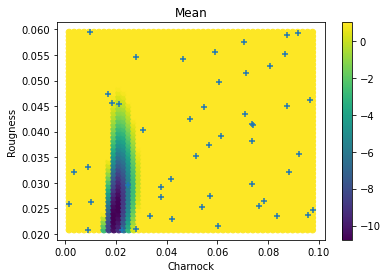

In [267]:
plt.scatter(xx[:,0],xx[:,1],c=mean,vmax=1)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],marker='+')
plt.title("Mean");
plt.xlabel("Charnock")
plt.ylabel("Rougness");


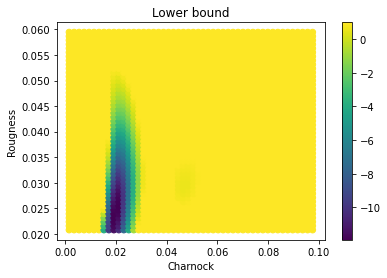

In [268]:
plt.scatter(xx[:,0], xx[:,1],c=mean - 2*np.sqrt(var),vmax=1)
plt.colorbar()
plt.title("Lower bound");
plt.xlabel("Charnock")
plt.ylabel("Rougness");

# Random forest

In [244]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X,Y)

RandomForestRegressor()

In [245]:
y_pred = rf.predict(xx)

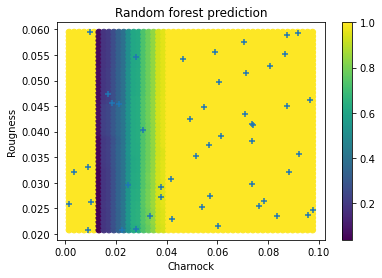

In [270]:
plt.scatter(xx[:,0],xx[:,1],c=y_pred,vmax=1)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],marker='+')
plt.title("Random forest prediction")
plt.xlabel("Charnock")
plt.ylabel("Rougness");